In [ ]:
import matplotlib
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Liberation Serif'
# plt.rcParams['font.family'] = 'Liberation Serif Bold'
from matplotlib.font_manager import FontProperties
print("Current font:", FontProperties().get_name())

当前字体: Liberation Serif


## 0. BEM blade dividing

In [7]:
import numpy as np
import math

#==================.exe Compiler#=======================

# Set the range and distribution of r
num_elements = 10  # Number of blade elements
R = 8.5
r_start = 2.473  # Starting radius (m)
r_end = 8.5      # Ending radius (m)
c_start = 1.545  # Starting chord length (m)
c_end = 0.927    # Ending chord length (m)a

# Use linspace to generate evenly spaced r values, num_elements + 1 points, forming num_elements segments
delta_r = (r_end - r_start) / num_elements  # Width of each segment δr
radii = np.linspace(r_start, r_end, num_elements + 1)
chord_lengths = np.linspace(c_start, c_end, num_elements + 1)

theta_root = math.radians(10)
theta_tip = math.radians(0)

def get_twist_angle(r, r_start, R, theta_root, theta_tip):
    return theta_root - (theta_root - theta_tip) * ((r - r_start) / (R - r_start))

print("r (m)    twist (deg)")
for r in radii:
    twist = get_twist_angle(r, r_start, R, theta_root, theta_tip)
    print(f"{r:6.3f}   {math.degrees(twist):6.2f}")
print("Width of each segment δr:", delta_r)
print("Radius values (radii):", radii)
print("Chord length values (chord):", chord_lengths)


r (m)    twist (deg)
 2.473    10.00
 3.076     9.00
 3.678     8.00
 4.281     7.00
 4.884     6.00
 5.486     5.00
 6.089     4.00
 6.692     3.00
 7.295     2.00
 7.897     1.00
 8.500     0.00
Width of each segment δr: 0.6027
Radius values (radii): [2.473  3.0757 3.6784 4.2811 4.8838 5.4865 6.0892 6.6919 7.2946 7.8973
 8.5   ]
Chord length values (chord): [1.545  1.4832 1.4214 1.3596 1.2978 1.236  1.1742 1.1124 1.0506 0.9888
 0.927 ]


## 1. Define U_infinity to get a and a'

In [8]:
import numpy as np
import math

# Parameter settings
U_infinity = 2  # Free-stream velocity (m/s)
omega = 1   # Rotational speed (rad/s)
R = 8.5  # Fixed total blade radius (m)
B = 3  # Number of blades
tolerance = 1e-6  # Convergence tolerance for iterations
small_value = 1e-6  # Small value to prevent division by zero errors

# Initial CL, CD values
CL_initial = np.array([0.00000, 0.11060, 0.22060, 0.32930, 0.43620, 0.54070, 0.64220, 0.75230, 0.87660, 0.99990, 1.07670])
CD_initial = np.array([0.00096, 0.00097, 0.00100, 0.00106, 0.00115, 0.00127, 0.00141, 0.00163, 0.00192, 0.00233, 0.00300])

# Twist angle parameters
theta_root = math.radians(10)  # Twist angle at the root (10°)
theta_tip = math.radians(0)   # Twist angle at the tip (0°)

# Function to calculate the twist angle at a given radius
def get_twist_angle(r, r_start, R, theta_root, theta_tip):
    return theta_root - (theta_root - theta_tip) * ((r - r_start) / (R - r_start))

# Prandtl tip loss factor calculation function
def prandtl_tip_loss(B, r, R, phi):
    if abs(r - R) < small_value:
        return 0.35  # When r = R, F = 0.25
    f = (B / 2) * (R - r) / (r * math.sin(phi))
    F = (2 / math.pi) * math.acos(math.exp(-f))
    return F

# Function to calculate the force projections T matrix
def calculate_forces_projection(CL, CD, phi):
    # Calculate the T matrix and apply it to [CL, CD]
    T = np.array([[math.cos(phi), math.sin(phi)],
                  [math.sin(phi), -math.cos(phi)]])
    forces = np.array([CL, CD])
    projected_forces = T @ forces  # Matrix multiplication to compute
    Cn, Ct = projected_forces
    return Cn, Ct

# Function to calculate induction factors, considering the twist angle and the new formula
def calculate_induction_with_twist(a_init, a_prime_init, r, chord, CL, CD, consider_tip_loss):
    a = a_init
    a_prime = a_prime_init

    for _ in range(1000):
        # Calculate the twist angle and adjust the relative flow angle
        twist_angle = get_twist_angle(r, r_start, R, theta_root, theta_tip)
        phi = math.atan((1 - a) * U_infinity / ((1 + a_prime) * omega * r + small_value)) - twist_angle

        # Calculate Cn and Ct based on the adjusted phi value
        Cn, Ct = calculate_forces_projection(CL, CD, phi)

        # Calculate Prandtl tip loss factor
        if consider_tip_loss:
            F = prandtl_tip_loss(B, r, R, phi)
        else:
            F = 1  # No tip loss considered

        # Calculate the Solidity of the blade loading coefficient sigma
        sigma = chord / (2 * math.pi * r)

        # Update a and a_prime
        a_new = 1 / (1 + F * (4 * math.sin(phi)**2) / (sigma * Cn + small_value))
        a_prime_new = 1 / (F * (4 * math.sin(phi) * math.cos(phi) / (sigma * Ct + small_value)) - 1)

        # Check convergence conditions
        if abs(a_new - a) < tolerance and abs(a_prime_new - a_prime) < tolerance:
            a, a_prime = a_new, a_prime_new
            break
        # Update induction factors
        a, a_prime = a_new, a_prime_new

    return a, a_prime, F, Cn, Ct

# Initialize result arrays
a_no_tip = []
a_prime_no_tip = []
a_with_tip = []
a_prime_with_tip = []
F_values = []
Cn_initial = []
Ct_initial = []

# Calculate induction factors and tip loss factors for each radius value
for i, r in enumerate(radii):
    CL = CL_initial[i]
    CD = CD_initial[i]
    chord = chord_lengths[i]

    # Calculate induction factors without considering tip loss
    a_nt, a_prime_nt, _, Cn, Ct = calculate_induction_with_twist(0.3, 0.01, r, chord, CL, CD, consider_tip_loss=False)
    a_no_tip.append(a_nt)
    a_prime_no_tip.append(a_prime_nt)

    # Calculate induction factors with considering tip loss
    a_wt, a_prime_wt, F, Cn, Ct = calculate_induction_with_twist(0.3, 0.01, r, chord, CL, CD, consider_tip_loss=True)
    a_with_tip.append(a_wt)
    a_prime_with_tip.append(a_prime_wt)
    F_values.append(F)
    Cn_initial.append(Cn)
    Ct_initial.append(Ct)

# Output the results
print("Radius (r)  | a (No Tip Loss) | a' (No Tip Loss) | a (With Tip Loss) | a' (With Tip Loss) | Tip Loss Factor F |    Cn    |    Ct    |    CL   |   CD  ")
for i, r in enumerate(radii):
    print(f"{r:.3f}     | {a_no_tip[i]:.6f}      | {a_prime_no_tip[i]:.6f}       | "
          f"{a_with_tip[i]:.6f}       | {a_prime_with_tip[i]:.6f}      | {F_values[i]:.4f}    | "
          f"{Cn_initial[i]:.6f} | {Ct_initial[i]:.6f} | {CL_initial[i]:.4f}  | {CD_initial[i]:.4f}")

Radius (r)  | a (No Tip Loss) | a' (No Tip Loss) | a (With Tip Loss) | a' (With Tip Loss) | Tip Loss Factor F |    Cn    |    Ct    |    CL   |   CD  
2.473     | 0.000050      | -0.000049       | 0.000050       | -0.000049      | 0.9997    | 0.000465 | -0.000840 | 0.0000  | 0.0010
3.076     | 0.011972      | 0.002276       | 0.011982       | 0.002278      | 0.9991    | 0.101692 | 0.043496 | 0.1106  | 0.0010
3.678     | 0.027123      | 0.003573       | 0.027178       | 0.003580      | 0.9981    | 0.207908 | 0.073754 | 0.2206  | 0.0010
4.281     | 0.044740      | 0.004324       | 0.044936       | 0.004341      | 0.9960    | 0.315299 | 0.095006 | 0.3293  | 0.0011
4.884     | 0.063217      | 0.004749       | 0.063828       | 0.004789      | 0.9916    | 0.421859 | 0.110935 | 0.4362  | 0.0011
5.486     | 0.080176      | 0.004960       | 0.081936       | 0.005052      | 0.9817    | 0.526238 | 0.124225 | 0.5407  | 0.0013
6.089     | 0.093034      | 0.005024       | 0.097767       | 0.005234  

In [1]:
# @title Tip Loss Check
import math
import numpy as np

# Fixed parameters
U_infinity = 2        # Free-stream velocity (m/s)
omega = 1             # Rotational speed (rad/s)
R = 8.5               # Blade tip radius (m)
B = 3                 # Number of blades
tolerance = 1e-6      # Iteration convergence tolerance
small_value = 1e-6    # To prevent division by zero

theta_root = math.radians(10)  # Twist angle at root (10°)
theta_tip = math.radians(0)    # Twist angle at tip (0°)

# For data at r = R
r = R
chord = 0.927
CL = 1.07670
CD = 0.00300

def get_twist_angle(r, R, theta_root, theta_tip):
    return theta_root - (theta_root - theta_tip) * (r / R)

def prandtl_tip_loss(B, r, R, phi):
    # When r is close to R, directly return assumed F=0.6
    if abs(r - R) < small_value:
        return 0.6
    f = (B / 2) * (R - r) / (r * math.sin(phi))
    F = (2 / math.pi) * math.acos(math.exp(-f))
    return F

def calculate_forces_projection(CL, CD, phi):
    # Compute T matrix and apply it to [CL, CD]
    T = np.array([[math.cos(phi), math.sin(phi)],
                  [math.sin(phi), -math.cos(phi)]])
    forces = np.array([CL, CD])
    projected_forces = T @ forces  # Matrix multiplication
    Cn, Ct = projected_forces
    return Cn, Ct

def calculate_induction_with_twist_debug(a_init, a_prime_init, r, chord, CL, CD, consider_tip_loss):
    a = a_init
    a_prime = a_prime_init
    print(f"[Debug Info] r = {r:.3f} m, chord = {chord:.3f} m, CL = {CL}, CD = {CD}")
    for it in range(1000):
        twist_angle = get_twist_angle(r, R, theta_root, theta_tip)
        # Calculate relative inflow angle phi (minus twist angle)
        phi = math.atan((1 - a) * U_infinity / ((1 + a_prime) * omega * r + small_value)) - twist_angle

        # When considering tip loss and r==R, directly return F = 0.6
        if consider_tip_loss:
            F = prandtl_tip_loss(B, r, R, phi)
        else:
            F = 1

        Cn, Ct = calculate_forces_projection(CL, CD, phi)
        sigma = chord / (2 * math.pi * r)

        # Update formulas for a and a′
        a_new = 1 / (1 + F * (4 * math.sin(phi)**2) / (sigma * Cn + small_value))
        a_prime_new = 1 / (F * (4 * math.sin(phi) * math.cos(phi) / (sigma * Ct + small_value)) - 1)

        print(f"Iteration {it:2d}: φ = {phi:.6f} rad, a = {a_new:.6f}, a' = {a_prime_new:.6f}, F = {F:.4f}")

        # Check for convergence
        if abs(a_new - a) < tolerance and abs(a_prime_new - a_prime) < tolerance:
            a, a_prime = a_new, a_prime_new
            break
        a, a_prime = a_new, a_prime_new

    return a, a_prime, F, Cn, Ct

print("----- Iteration Debug: With Tip Loss (F = 0.6 when r = R) -----")
a_with_tip, a_prime_with_tip, F_with_tip, Cn_with_tip, Ct_with_tip = calculate_induction_with_twist_debug(
    0.3, 0.01, r, chord, CL, CD, consider_tip_loss=True
)
print("\nFinal Result (With Tip Loss): a = {:.6f}, a' = {:.6f}, F = {:.4f}".format(
    a_with_tip, a_prime_with_tip, F_with_tip))


----- Iteration Debug: With Tip Loss (F = 0.6 when r = R) -----
[Debug Info] r = 8.500 m, chord = 0.927 m, CL = 1.0767, CD = 0.003
Iteration  0: φ = 0.161652 rad, a = 0.228889, a' = 0.007818, F = 0.6000
Iteration  1: φ = 0.178122 rad, a = 0.196305, a' = 0.007853, F = 0.6000
Iteration  2: φ = 0.185475 rad, a = 0.183790, a' = 0.007869, F = 0.6000
Iteration  3: φ = 0.188293 rad, a = 0.179283, a' = 0.007875, F = 0.6000
Iteration  4: φ = 0.189307 rad, a = 0.177699, a' = 0.007877, F = 0.6000
Iteration  5: φ = 0.189663 rad, a = 0.177146, a' = 0.007878, F = 0.6000
Iteration  6: φ = 0.189787 rad, a = 0.176955, a' = 0.007878, F = 0.6000
Iteration  7: φ = 0.189830 rad, a = 0.176888, a' = 0.007878, F = 0.6000
Iteration  8: φ = 0.189845 rad, a = 0.176865, a' = 0.007878, F = 0.6000
Iteration  9: φ = 0.189851 rad, a = 0.176857, a' = 0.007878, F = 0.6000
Iteration 10: φ = 0.189852 rad, a = 0.176854, a' = 0.007878, F = 0.6000
Iteration 11: φ = 0.189853 rad, a = 0.176853, a' = 0.007878, F = 0.6000

Fina

## 2. Calculate Relative velocity **Urel** and Flow angle **phi**

In [9]:
# Initialize the lists to store intermediate results
one_minus_a_U_infinity = []
one_plus_a_prime_omega_r = []
Urel_values = []
tan_phi_values = []
phi_values = []
phi_minus_twist_values = []
twist_angles_deg = []  # New: list to store twist angles in degrees

# Calculate intermediate variables for each radial position
for i, r in enumerate(radii):
    a = a_no_tip[i]
    a_prime = a_prime_no_tip[i]
    chord = chord_lengths[i]
    CL = CL_initial[i]
    CD = CD_initial[i]

    one_minus_a_Uinf = (1 - a) * U_infinity
    one_plus_a_prime_omega_r_val = (1 + a_prime) * omega * r

    Urel = math.sqrt(one_minus_a_Uinf**2 + one_plus_a_prime_omega_r_val**2)

    tan_phi = one_minus_a_Uinf / (one_plus_a_prime_omega_r_val + small_value)
    phi = math.degrees(math.atan(tan_phi))

    twist_angle = get_twist_angle(r, r_start, R, theta_root, theta_tip)
    twist_angle_deg = math.degrees(twist_angle)
    phi_minus_twist = phi - twist_angle_deg

    one_minus_a_U_infinity.append(one_minus_a_Uinf)
    one_plus_a_prime_omega_r.append(one_plus_a_prime_omega_r_val)
    Urel_values.append(Urel)
    tan_phi_values.append(tan_phi)
    phi_values.append(phi)
    twist_angles_deg.append(twist_angle_deg)
    phi_minus_twist_values.append(phi_minus_twist)

print("\nRadius (r)  | (1-a)U∞  | (1+a')ωr |   U_rel  | tan(phi) |  phi(deg) | twist(deg)| phi - twist(r)")
for i, r in enumerate(radii):
    print(f"{r:.3f}     | {one_minus_a_U_infinity[i]:.6f} | {one_plus_a_prime_omega_r[i]:.6f} | "
          f"{Urel_values[i]:.6f} | {tan_phi_values[i]:.6f} | {phi_values[i]:.6f} | {twist_angles_deg[i]:8.6f} | {phi_minus_twist_values[i]:.6f}")



Radius (r)  | (1-a)U∞  | (1+a')ωr |   U_rel  | tan(phi) |  phi(deg) | twist(deg)| phi - twist(r)
2.473     | 1.999899 | 2.472880 | 3.180366 | 0.808733 | 38.963600 | 10.000000 | 28.963600
3.076     | 1.976057 | 3.082701 | 3.661673 | 0.641014 | 32.660455 | 9.000000 | 23.660455
3.678     | 1.945753 | 3.691542 | 4.172941 | 0.527084 | 27.792995 | 8.000000 | 19.792995
4.281     | 1.910519 | 4.299611 | 4.704969 | 0.444347 | 23.957822 | 7.000000 | 16.957822
4.884     | 1.873566 | 4.906991 | 5.252505 | 0.381815 | 20.897631 | 6.000000 | 14.897631
5.486     | 1.839648 | 5.513713 | 5.812515 | 0.333649 | 18.451249 | 5.000000 | 13.451249
6.089     | 1.813932 | 6.119789 | 6.382959 | 0.296404 | 16.510046 | 4.000000 | 12.510046
6.692     | 1.796006 | 6.725766 | 6.961434 | 0.267034 | 14.951047 | 3.000000 | 11.951047
7.295     | 1.785881 | 7.331822 | 7.546190 | 0.243579 | 13.689487 | 2.000000 | 11.689487
7.897     | 1.787557 | 7.937231 | 8.136031 | 0.225212 | 12.691924 | 1.000000 | 11.691924
8.500     |

## 3. Lift & Drag and Normal & Tangential Force

In [10]:
rho = 1025  # Water density (kg/m³)
CL_star = np.array([1.1812, 1.3106, 1.8220, 1.7370, 1.5985, 1.4654, 1.3702, 1.3050, 1.2589, 1.1811, 0.7782])
CD_star = np.array([0.37960, 0.16813, 0.03441, 0.01943, 0.01494, 0.01283, 0.01154, 0.01074, 0.01017, 0.00951, 0.00693])

# Initialize storage lists for forces
lift_initial, drag_initial = [], []
Fn_initial, Ft_initial = [], []
lift_star, drag_star = [], []
Fn_star, Ft_star = [], []
Cn_star_values, Ct_star_values = [], []  # Directly using * version of Cn and Ct

# Calculate forces for each radius position
for i, r in enumerate(radii):
    Urel = Urel_values[i]  # Ensure Urel_values are computed via BEM
    chord = chord_lengths[i]

    # Calculate Cn* and Ct*
    phi = math.atan((1 - a_with_tip[i]) * U_infinity / ((1 + a_prime_with_tip[i]) * omega * r))
    Cn_star, Ct_star = calculate_forces_projection(CL_star[i], CD_star[i], phi)
    Cn_star_values.append(Cn_star)
    Ct_star_values.append(Ct_star)

    # **Initial force calculations (using Cn_initial and Ct_initial)**
    L_initial = 0.5 * rho * Urel**2 * chord * delta_r * CL_initial[i] / 1000
    D_initial = 0.5 * rho * Urel**2 * chord * delta_r * CD_initial[i] / 1000
    Fn_initial_val = Cn_initial[i] * 0.5 * rho * Urel**2 * chord * delta_r / 1000
    Ft_initial_val = Ct_initial[i] * 0.5 * rho * Urel**2 * chord * delta_r / 1000

    lift_initial.append(L_initial)
    drag_initial.append(D_initial)
    Fn_initial.append(Fn_initial_val)
    Ft_initial.append(Ft_initial_val)

    # **Secondary force calculations (using CL_star/CD_star)**
    L_star = 0.5 * rho * Urel**2 * chord * delta_r * CL_star[i] / 1000
    D_star = 0.5 * rho * Urel**2 * chord * delta_r * CD_star[i] / 1000

    Fn_star_val = Cn_star * 0.5 * rho * Urel**2 * chord * delta_r / 1000
    Ft_star_val = Ct_star * 0.5 * rho * Urel**2 * chord * delta_r / 1000

    lift_star.append(L_star)
    drag_star.append(D_star)
    Fn_star.append(Fn_star_val)
    Ft_star.append(Ft_star_val)

# ====================== Output Calculations ======================

# Print initial force results
print("Radius(r) |     L (kN)     |     D (kN)    |    Fn (kN)   |     Ft (kN)   |    Cn    |    Ct    |    CL    |  CD  |")
for i, r in enumerate(radii):
    print(f"{r:.3f}  | {lift_initial[i]:.6f} kN   | {drag_initial[i]:.6f} kN   | "
          f"{Fn_initial[i]:.6f} kN   | {Ft_initial[i]:.6f} kN   | "
          f"{Cn_initial[i]:.6f} | {Ct_initial[i]:.6f} | {CL_initial[i]:.4f}  | {CD_initial[i]:.4f}")

# Print adjusted star-force results
print("Radius(r) |     L* (kN)    |     D* (kN)    |    Fn* (kN)   |    Ft* (kN)   |    Cn*   |    Ct*   |    CL*  | CD*  |")
for i, r in enumerate(radii):
    print(f"{r:.3f}  | {lift_star[i]:.6f} kN   | {drag_star[i]:.6f} kN   | "
          f"{Fn_star[i]:.6f} kN   | {Ft_star[i]:.6f} kN   | "
          f"{Cn_star_values[i]:.6f} | {Ct_star_values[i]:.6f} | {CL_star[i]:.4f}  | {CD_star[i]:.4f}")


Radius(r) |     L (kN)     |     D (kN)    |    Fn (kN)   |     Ft (kN)   |    Cn    |    Ct    |    CL    |  CD  |
2.473  | 0.000000 kN   | 0.004634 kN   | 0.002244 kN   | -0.004054 kN   | 0.000465 | -0.000840 | 0.0000  | 0.0010
3.076  | 0.679374 kN   | 0.005958 kN   | 0.624659 kN   | 0.267182 kN   | 0.101692 | 0.043496 | 0.1106  | 0.0010
3.678  | 1.686559 kN   | 0.007645 kN   | 1.589524 kN   | 0.563872 kN   | 0.207908 | 0.073754 | 0.2206  | 0.0010
4.281  | 3.061340 kN   | 0.009854 kN   | 2.931179 kN   | 0.883226 kN   | 0.315299 | 0.095006 | 0.3293  | 0.0011
4.884  | 4.824158 kN   | 0.012718 kN   | 4.665555 kN   | 1.226889 kN   | 0.421859 | 0.110935 | 0.4362  | 0.0011
5.486  | 6.974260 kN   | 0.016381 kN   | 6.787720 kN   | 1.602320 kN   | 0.526238 | 0.124225 | 0.5407  | 0.0013
6.089  | 9.489680 kN   | 0.020835 kN   | 9.271890 kN   | 2.021512 kN   | 0.627461 | 0.136803 | 0.6422  | 0.0014
6.692  | 12.526926 kN   | 0.027142 kN   | 12.269843 kN   | 2.524987 kN   | 0.736861 | 0.151637 | 0

In [11]:
# Compute the average of adjacent rows to obtain 10 rows of results
avg_radii = []
avg_lift_star = []
avg_drag_star = []
avg_Fn_star = []
avg_Ft_star = []
avg_Cn_star = []
avg_Ct_star = []

for i in range(len(radii) - 1):  # Prevent index out of range
    avg_radii.append((radii[i] + radii[i + 1]) / 2)
    avg_lift_star.append((lift_star[i] + lift_star[i + 1]) / 2)
    avg_drag_star.append((drag_star[i] + drag_star[i + 1]) / 2)
    avg_Fn_star.append((Fn_star[i] + Fn_star[i + 1]) / 2)
    avg_Ft_star.append((Ft_star[i] + Ft_star[i + 1]) / 2)
    avg_Cn_star.append((Cn_star_values[i] + Cn_star_values[i + 1]) / 2)
    avg_Ct_star.append((Ct_star_values[i] + Ct_star_values[i + 1]) / 2)

# Output the 10-row averaged results
print("\nAveraged 10 rows of results:")
print("Radius (r) | Avg Lift δL* (N) | Avg Drag δD* (N) | Avg Normal Force δFn* (N) | Avg Tangential Force δFt* (N)")
for i in range(len(avg_radii)):  # Prevent index out of range
    print(f"{avg_radii[i]:.3f}     | {avg_lift_star[i]:.6f} N     | {avg_drag_star[i]:.6f} N     | "
          f"{avg_Fn_star[i]:.6f} N      | {avg_Ft_star[i]:.6f} N")



Averaged 10 rows of results:
Radius (r) | Avg Lift δL* (N) | Avg Drag δD* (N) | Avg Normal Force δFn* (N) | Avg Tangential Force δFt* (N)
2.774     | 6.876091 N     | 1.432545 N     | 6.460239 N      | 2.817835 N
3.377     | 10.990151 N     | 0.647917 N     | 9.890300 N      | 4.868572 N
3.980     | 15.038907 N     | 0.221853 N     | 13.638155 N      | 6.326476 N
4.582     | 16.913329 N     | 0.172930 N     | 15.703367 N      | 6.269309 N
5.185     | 18.290099 N     | 0.165359 N     | 17.280925 N      | 5.981136 N
5.788     | 19.574392 N     | 0.168007 N     | 18.727455 N      | 5.688067 N
6.391     | 20.988712 N     | 0.174681 N     | 20.264264 N      | 5.461103 N
6.993     | 22.496965 N     | 0.183386 N     | 21.874111 N      | 5.251923 N
7.596     | 23.571338 N     | 0.190102 N     | 23.060631 N      | 4.871765 N
8.199     | 20.429346 N     | 0.171738 N     | 20.153390 N      | 3.247610 N


## 4. Output csv file


In [12]:
import pandas as pd
from google.colab import files

output_file = 'Fast_BEM_Force_Solver_results.csv'

Fast_BEM_results = pd.DataFrame({
    "Element number": list(range(0, num_elements + 1)),
    "radii": radii,
    "a": a_no_tip,
    "a'": a_prime_no_tip,
    "a_corr": a_with_tip,
    "a'_corr": a_prime_with_tip,
    "F_tiploss": F_values,
    "(1-a)U_infnty": one_minus_a_U_infinity,
    "(1+a')wr": one_plus_a_prime_omega_r,
    "Urel": Urel_values,
    "tan(phi)": tan_phi_values,
    "phi": phi_values,
    "phi-twist": phi_minus_twist_values,
    "L*": lift_star,
    "D*": drag_star,
    "L": lift_initial,
    "D": drag_initial,
    "Fn*": Fn_star,
    "Ft*": Ft_star,
    "Fn": Fn_initial,
    "Ft": Ft_initial,
    "Cn*": Cn_star_values,
    "Ct*": Ct_star_values,
    "Cn": Cn_initial,
    "Ct": Ct_initial,
    "CL*": CL_star,
    "CD*": CD_star,
    "CL_ini": CL_initial,
    "CD_ini": CD_initial,
})

Fast_BEM_results.to_csv(output_file, index=False)

# 仅在 Colab 需要下载
try:
    from google.colab import files
    files.download(output_file)
except:
    print(f"File saved as: {output_file}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Visualisation

<ipython-input-16-95f8c13c44a1>:72: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(data['x'], data['y'], color=data['color'], label=label,


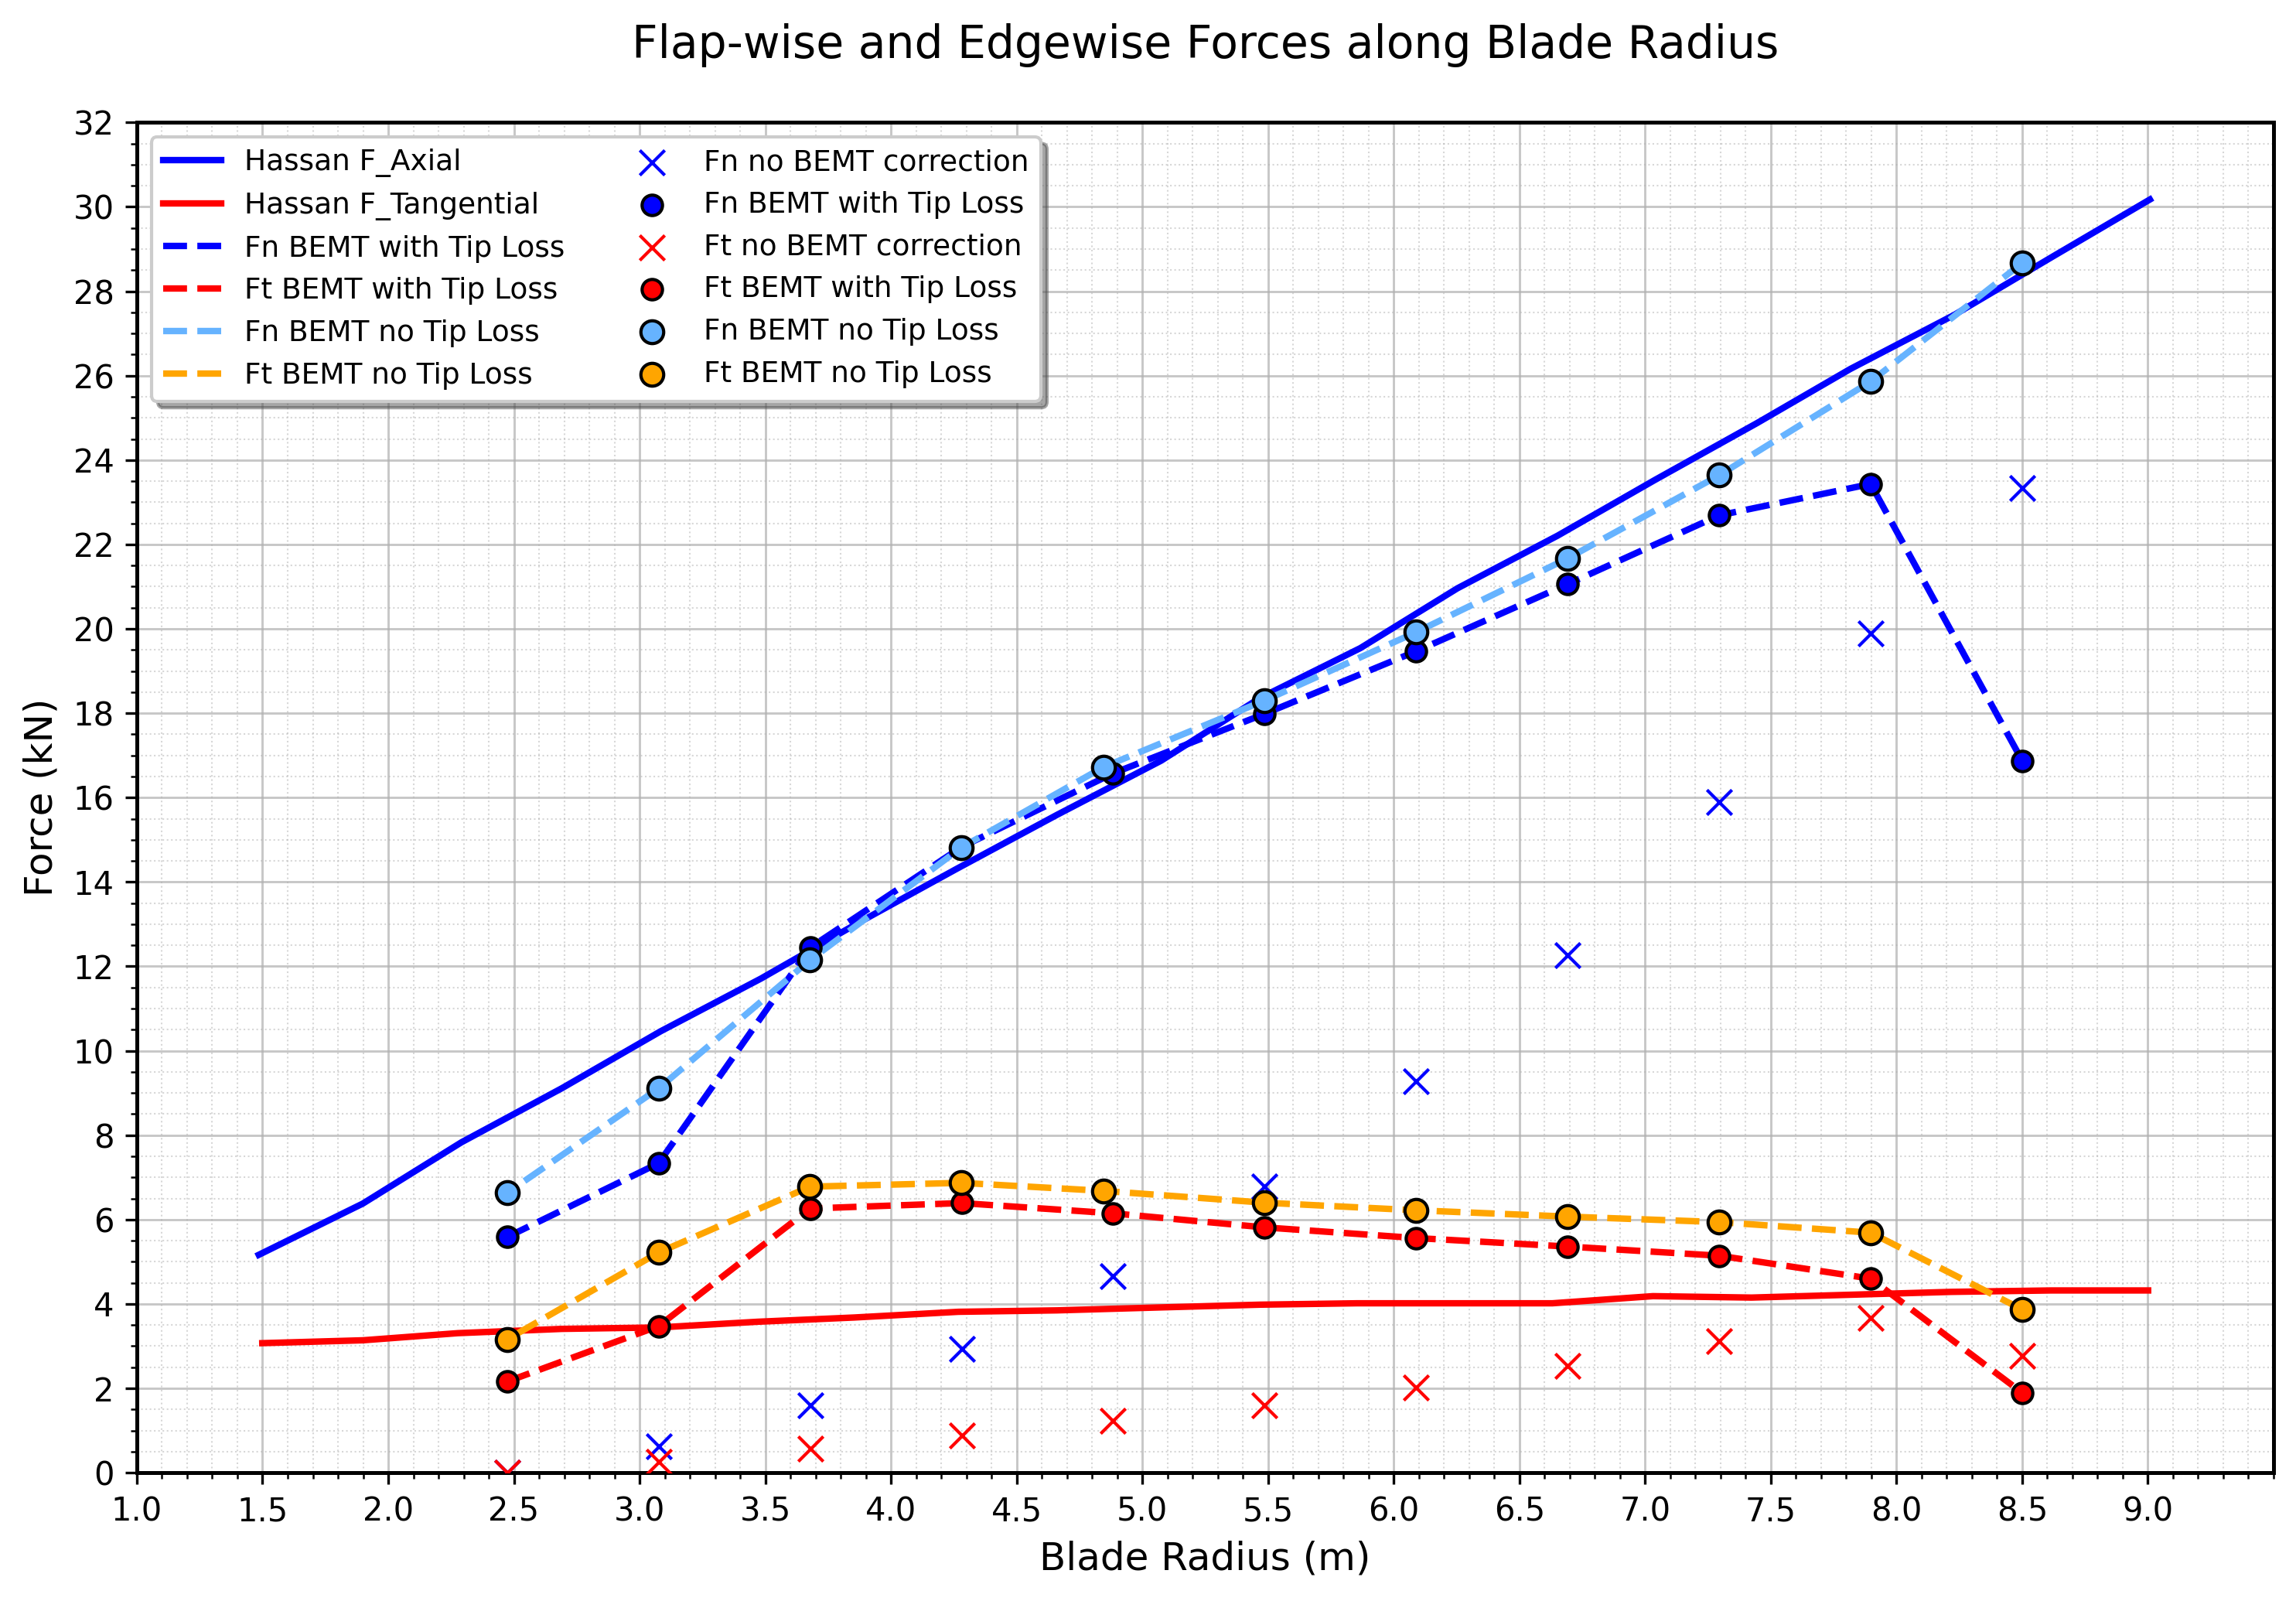

In [16]:
import matplotlib.pyplot as plt
import numpy as np

lines = {
    'Hassan F_Axial': {'x': [1.485, 1.899, 2.291, 2.691, 3.084, 3.483, 3.869, 4.261, 4.661, 5.075, 5.468, 5.867, 6.253, 6.652, 7.038, 7.445, 7.816, 8.230, 8.622, 9.008],
                      'y': [5.164, 6.379, 7.830, 9.113, 10.463, 11.712, 13.028, 14.311, 15.593, 16.876, 18.361, 19.542, 20.959, 22.208, 23.525, 24.875, 26.157, 27.440, 28.824, 30.174],
                      'color': 'blue'},
    'Hassan F_Tangential': {'x': [1.499, 1.899, 2.277, 2.691, 3.076, 3.469, 3.854, 4.268, 4.661, 5.054, 5.468, 5.853, 6.231, 6.631, 7.031, 7.423, 7.823, 8.216, 8.615, 9.001],
                           'y': [3.071, 3.139, 3.308, 3.409, 3.443, 3.578, 3.679, 3.814, 3.848, 3.915, 3.983, 4.016, 4.016, 4.016, 4.185, 4.151, 4.219, 4.286, 4.320, 4.320],
                           'color': 'red'},
    'Fn BEMT with Tip Loss': {
        'x': Fast_BEM_results['radii'], 'y': Fast_BEM_results['Fn*'],
        'color': 'blue'
    },
    'Ft BEMT with Tip Loss': {
        'x': Fast_BEM_results['radii'], 'y': Fast_BEM_results['Ft*'],
        'color': 'red'
    },
    'Fn BEMT no Tip Loss': {
        'x': [8.500, 7.897, 7.295, 6.692, 6.089, 5.486, 4.844, 4.281, 3.678, 3.076, 2.473],
        'y': [28.67, 25.86, 23.64, 21.67, 19.92, 18.30, 16.72, 14.82, 12.15, 9.11, 6.63],
        'color': '#66b3ff'  # Bright blue
    },
    'Ft BEMT no Tip Loss': {
        'x': [8.500, 7.897, 7.295, 6.692, 6.089, 5.486, 4.844, 4.281, 3.678, 3.076, 2.473],
        'y': [3.87, 5.69, 5.94, 6.07, 6.22, 6.4, 6.68, 6.87, 6.78, 5.22, 3.16],
        'color': 'orange'
    },
}

scatter_data = {
    'Fn no BEMT correction': {
        'x': Fast_BEM_results['radii'], 'y': Fast_BEM_results['Fn'],
        'color': 'blue', 'marker': 'x', 's': 60
    },
    'Fn BEMT with Tip Loss': {
        'x': Fast_BEM_results['radii'], 'y': Fast_BEM_results['Fn*'],
        'color': 'blue'
    },
    'Ft no BEMT correction': {
        'x': Fast_BEM_results['radii'], 'y': Fast_BEM_results['Ft'],
        'color': 'red', 'marker': 'x', 's': 60
    },
    'Ft BEMT with Tip Loss': {
        'x': Fast_BEM_results['radii'], 'y': Fast_BEM_results['Ft*'],
        'color': 'red'
    },

    'Fn BEMT no Tip Loss': {
        'x': [8.500, 7.897, 7.295, 6.692, 6.089, 5.486, 4.844, 4.281, 3.678, 3.076, 2.473],
        'y': [28.67, 25.86, 23.64, 21.67, 19.92, 18.30, 16.72, 14.82, 12.15, 9.11, 6.63],
        'color': '#66b3ff', 'marker': 'o', 's': 50
    },
    'Ft BEMT no Tip Loss': {
        'x': [8.500, 7.897, 7.295, 6.692, 6.089, 5.486, 4.844, 4.281, 3.678, 3.076, 2.473],
        'y': [3.87, 5.69, 5.94, 6.07, 6.22, 6.4, 6.68, 6.87, 6.78, 5.22, 3.16],
        'color': 'orange', 'marker': 'o', 's': 50
    },
}


plt.figure(figsize=(10, 7), dpi=300)

for label, data in lines.items():
    linestyle = '--' if ('Tip Loss' in label or 'no Tip Loss' in label) else '-'
    plt.plot(data['x'], data['y'], label=label, color=data['color'],
             linestyle=linestyle, linewidth=2)

for label, data in scatter_data.items():
    marker = data.get('marker', 'o')
    size = data.get('s', 40)
    plt.scatter(data['x'], data['y'], color=data['color'], label=label,
                zorder=5, marker=marker, s=size, edgecolors='k', linewidths=1)

plt.xlim(1, 9.5)
plt.ylim(0, 32)
plt.xticks(np.arange(1, 9.5, 0.5))
plt.yticks(np.arange(0, 33, 2))

plt.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
plt.minorticks_on()

plt.title('Flap-wise and Edgewise Forces along Blade Radius', fontsize=14, pad=20)
plt.xlabel('Blade Radius (m)', fontsize=12)
plt.ylabel('Force (kN)', fontsize=12)

plt.legend(fontsize=9, framealpha=1, shadow=True, loc='best', ncol=2)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


In [17]:
!pip install brokenaxes

/usr/local/lib/python3.11/dist-packages/brokenaxes.py:368: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 3
  return self.big_ax.legend(handles=handles, labels=labels, *args, **kwargs)
<ipython-input-18-20ebb7a0a6c3>:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


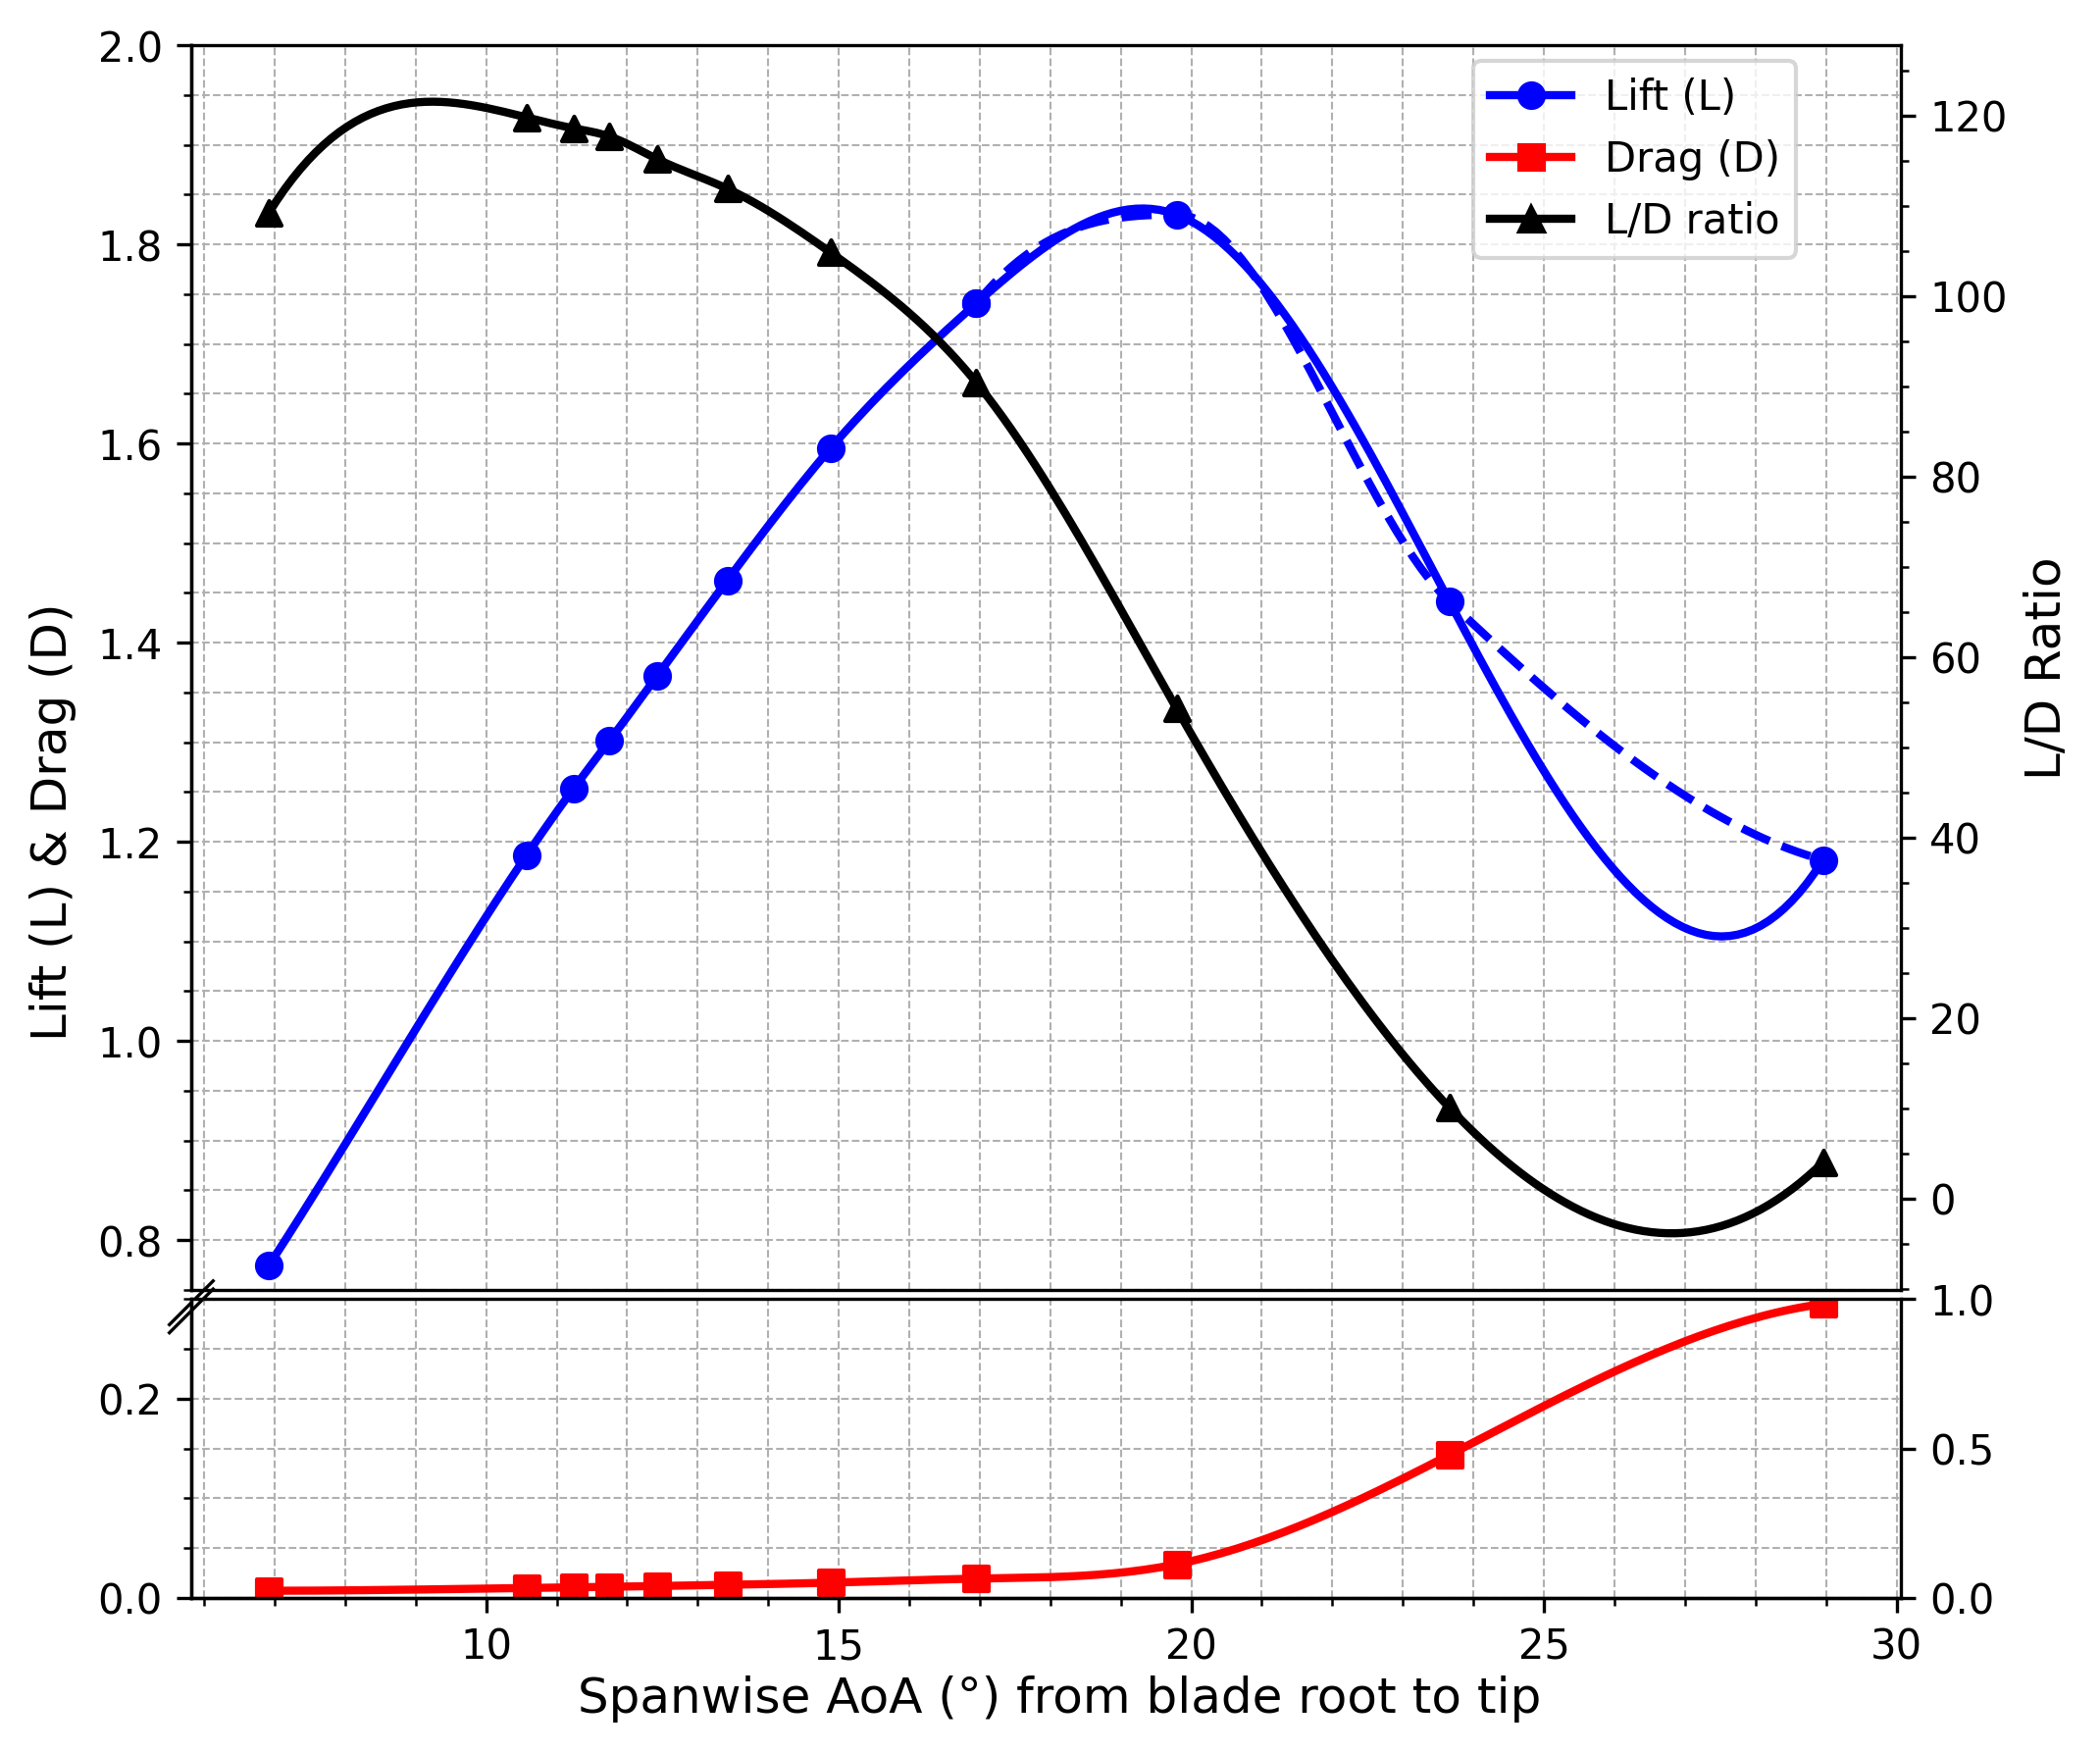

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, PchipInterpolator
from brokenaxes import brokenaxes
from matplotlib.lines import Line2D

# Data
alpha = np.array([28.96, 23.66, 19.79, 16.95, 14.88, 13.42, 12.43, 11.75, 11.24, 10.57, 6.92])
CL = np.array([1.1818, 1.4411, 1.8298, 1.7406, 1.5948, 1.4625, 1.367, 1.3016, 1.2535, 1.1861, 0.7746])
CD = np.array([0.29522, 0.14353, 0.0337, 0.01925, 0.01521, 0.01307, 0.01187, 0.01106, 0.01057, 0.0099, 0.00709])

# Calculate Lift (L), Drag (D), and L/D ratio
L = CL
D = CD
L_D = L / D

# Sort data by angle of attack (alpha)
sorted_indices = np.argsort(alpha)
alpha = alpha[sorted_indices]
L = L[sorted_indices]
D = D[sorted_indices]
L_D = L_D[sorted_indices]

# Extract the last three data points (maximum angle of attack region)
last_three_mask = alpha >= alpha[-4]  # Select the largest three alpha points
alpha_last3 = alpha[last_three_mask]
L_last3 = L[last_three_mask]

# Generate a monotonic decreasing interpolation (using PCHIP to preserve the shape)
pchip = PchipInterpolator(alpha_last3, L_last3)
alpha_smooth_last3 = np.linspace(alpha_last3[0], alpha_last3[-1], 100)
L_smooth_last3 = pchip(alpha_smooth_last3)

# Smooth curves (overall)
alpha_smooth = np.linspace(min(alpha), max(alpha), 200)
L_smooth = CubicSpline(alpha, L)(alpha_smooth)
D_smooth = CubicSpline(alpha, D)(alpha_smooth)
L_D_smooth = CubicSpline(alpha, L_D)(alpha_smooth)

# ------------------ Plotting Settings ------------------
fig = plt.figure(figsize=(7, 6), dpi=300)  # Adjust figure width

# Create broken axis plot (left side shows L and D)
bax = brokenaxes(
    ylims=((0, 0.3), (0.75, 2.0)),
    hspace=0.012,
    left=0.1,
    right=0.93  # Remove right-side empty space
)

# ========== Modification 1: Mark the first eight data points for L curve and hide the last three points as solid line ==========
# Lift (L) main curve (solid line)
bax.plot(alpha_smooth, L_smooth, color="blue", linestyle="-", lw=2, label="Lift (L)")
bax.scatter(alpha[:-3], L[:-3], color="blue", marker="o", zorder=3)  # Mark the first 8 points

# Lift (L) last 3 points corrected curve (dashed line)
bax.plot(alpha_smooth_last3, L_smooth_last3, color="blue", linestyle="--", lw=2, label="Lift (L) Last 3 Points")
bax.scatter(alpha_last3, L_last3, color="blue", marker="o", zorder=3)  # Mark the last 3 points

# Drag (D) curve (solid line)
bax.plot(alpha_smooth, D_smooth, color="red", linestyle="-", lw=2, label="Drag (D)")
bax.scatter(alpha, D, color="red", marker="s", zorder=3)

# ========== Right-axis (L/D) ==========
ax2 = bax.twinx()[0]  # Get the first brokenaxes axis
ax2.plot(alpha_smooth, L_D_smooth, color="black", linestyle="-", lw=2, label="L/D Ratio")
ax2.scatter(alpha, L_D, color="black", marker="^", zorder=3)
ax2.set_ylabel("L/D Ratio", color="black", fontsize=12, loc='center')
ax2.tick_params(axis="y", colors="black")

# ========== Set axis labels ==========
bax.set_xlabel("Spanwise AoA (°) from blade root to tip", fontsize=12, labelpad=19, loc='center')  # Increase labelpad to adjust downward
bax.set_ylabel("Lift (L) & Drag (D)", fontsize=12, labelpad=10, loc='center')

# ========== Add grid lines and minor ticks ==========
bax.grid(True, which='both', linestyle='--', linewidth=0.5)
bax.minorticks_on()
ax2.minorticks_on()

# ========== Fix legend: Ensure all curves are correctly displayed ==========
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, marker='o', label='Lift (L)'),
    Line2D([0], [0], color='red', lw=2, marker='s', label='Drag (D)'),
    Line2D([0], [0], color='black', lw=2, marker='^', label='L/D Ratio'),
    Line2D([0], [0], color='blue', lw=2, ls='--', label='Lift (L) Last 3 Points')
]

# Move the legend to the top-right outside of the figure
bax.legend(handles=legend_elements,
          loc='upper left',
          bbox_to_anchor=(0.72, 0.99),
          borderaxespad=0.)

plt.tight_layout()
plt.show()


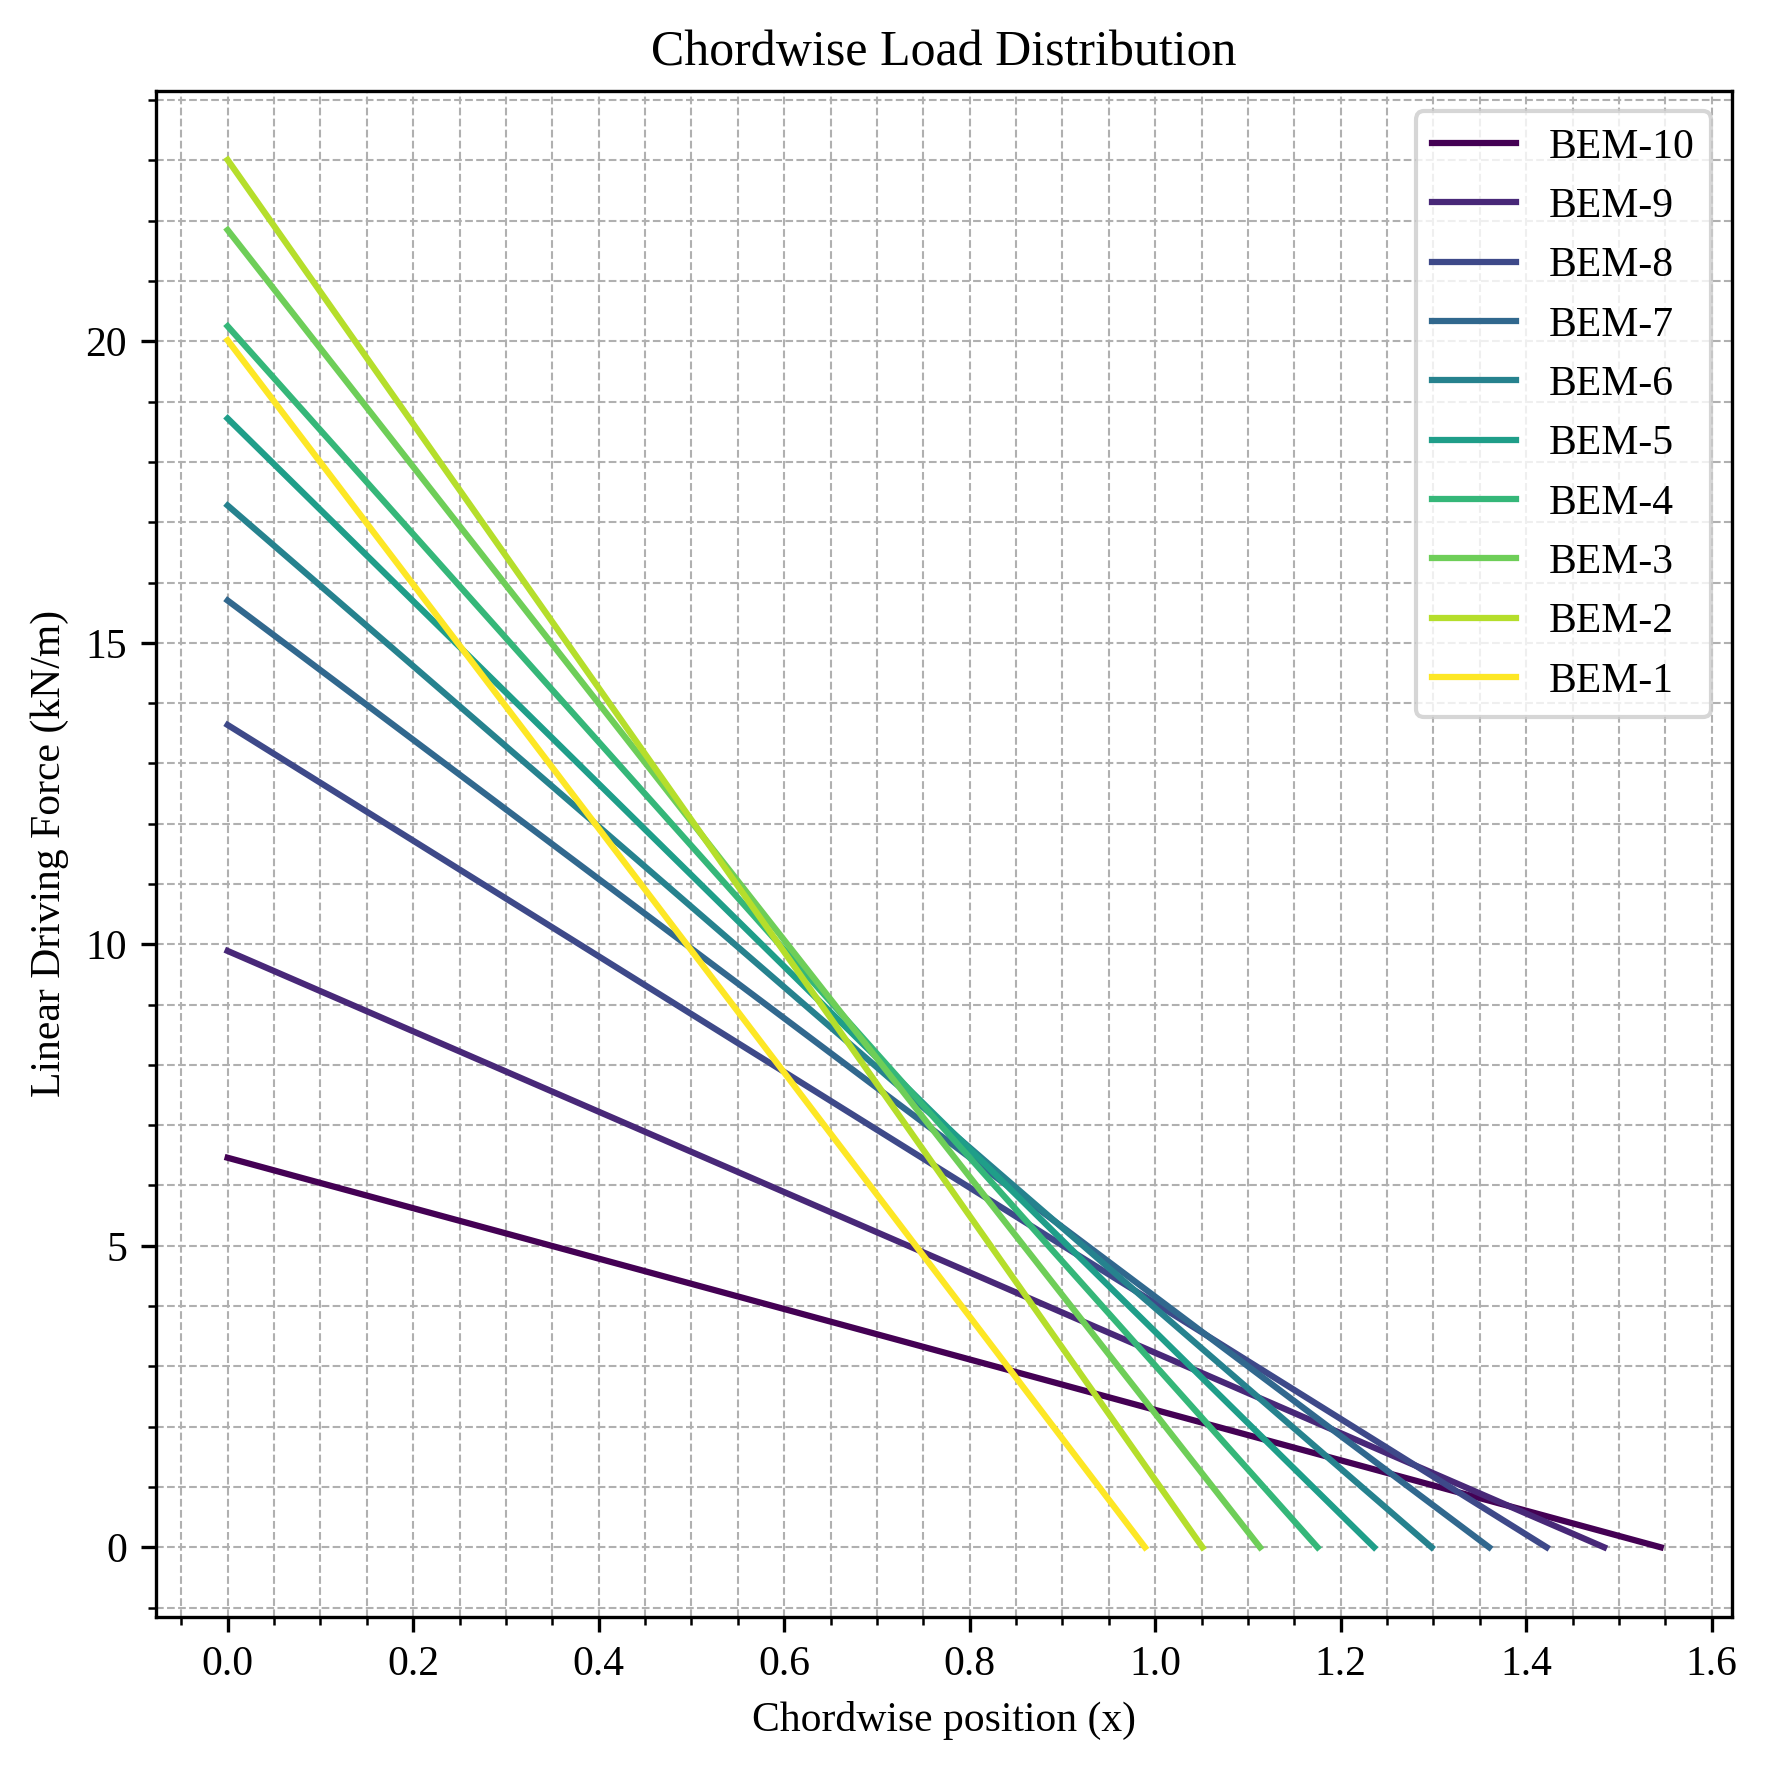

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Input data
d_star = np.array([1.545, 1.484, 1.422, 1.360, 1.298, 1.236, 1.175, 1.113, 1.051, 0.989])
delta_Fn = np.array([6460, 9890, 13638, 15702, 17278, 18721, 20251, 21847, 23010, 20018])

# Calculate slope 'a' and intercept 'b'
a_values = -delta_Fn / d_star
b_values = delta_Fn

# Use the viridis colormap (colorblind friendly)
colors = cm.viridis(np.linspace(0, 1, len(d_star)))

# Create the plot
plt.figure(figsize=(6, 6), dpi=300)

# Plot the chordwise load function for each element
for i in range(len(d_star)):
    x_vals = np.linspace(0, d_star[i], 100)  # Only within the range 0 to d*
    q_x = (a_values[i] * x_vals + b_values[i]) / 1000  # Convert to kN/m
    plt.plot(x_vals, q_x, label=f"BEM-{len(d_star)-i}", color=colors[i])

# Add labels, title, and grid
plt.xlabel("Chordwise position (x)")
plt.ylabel("Linear Driving Force (kN/m)")
plt.title("Chordwise Load Distribution")

# Add grid (dashed lines) and minor ticks
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

# Display the legend
plt.legend()
plt.tight_layout()
plt.show()
